In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Regression Intro: Transformin Target

- Run simple linear regression with sklearn
- Apply transformations to make target variable more normal distributed
- Apply inverse transformation to be able to use these in a regression context

In [2]:
with open('./data/boston_housing_clean.pickle', 'rb') as to_read:
    boston = pd.read_pickle(to_read)
boston_data = boston['dataframe']
boston_description = boston['description']
from pprint import pprint
pprint(boston_description)

('Boston House Prices dataset\n'
 '===========================\n'
 '\n'
 'Notes\n'
 '------\n'
 'Data Set Characteristics:  \n'
 '\n'
 '    :Number of Instances: 506 \n'
 '\n'
 '    :Number of Attributes: 13 numeric/categorical predictive\n'
 '    \n'
 '    :Median Value (attribute 14) is usually the target\n'
 '\n'
 '    :Attribute Information (in order):\n'
 '        - CRIM     per capita crime rate by town\n'
 '        - ZN       proportion of residential land zoned for lots over 25,000 '
 'sq.ft.\n'
 '        - INDUS    proportion of non-retail business acres per town\n'
 '        - CHAS     Charles River dummy variable (= 1 if tract bounds river; '
 '0 otherwise)\n'
 '        - NOX      nitric oxides concentration (parts per 10 million)\n'
 '        - RM       average number of rooms per dwelling\n'
 '        - AGE      proportion of owner-occupied units built prior to 1940\n'
 '        - DIS      weighted distances to five Boston employment centres\n'
 '        - RAD      index o

In [3]:
boston_data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Determining normality

- Visually => inspection via histogram
- Statistical test => D'Agostino K^2 test

We want to perform this on our target variable, which is `MEDV`, or the median value of a property.

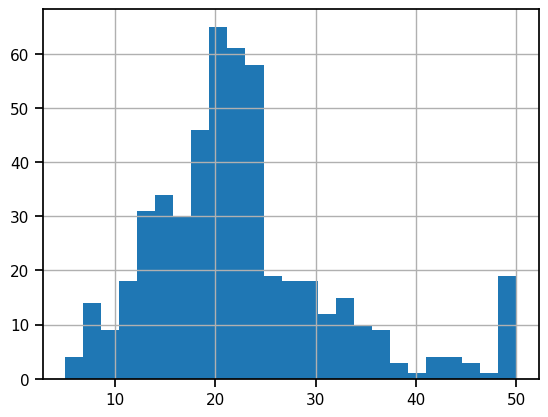

In [4]:
boston_data.MEDV.hist(bins=25);

In [5]:
from scipy.stats.mstats import normaltest
f"The p-value for the normal test is {normaltest(boston_data.MEDV.values).pvalue:.2e}"

'The p-value for the normal test is 1.76e-20'

With the p-value for this test being so low, we have determined that the data was *not* normally distributed. In this test, the null hypothesis is that the data is normally distributed, for a low p-value we *reject this null hypothesis*.

As before, we can simply use the log function to remove skew. And test afterwards if we get closer to a normally distributed value.

'The p-value for the normal test on log-transformed data is 1.82e-04'

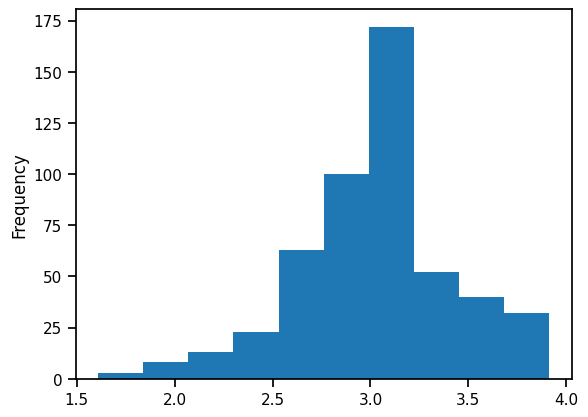

In [6]:
medv_log = np.log(boston_data["MEDV"])
medv_log.plot.hist()
f"The p-value for the normal test on log-transformed data is {normaltest(medv_log.values).pvalue:.2e}"

That is better, but still not above the usual threshold of p>0.05.

There are three common transformations to get data to be more normally distributed, they are:

- Log (that we did before)
- Square Root (same as log, but with sqrt instead)
- BoxCox (parametrised transformation with the goal of getting the data more towards normal)

In [16]:
from scipy.stats import boxcox

medv_log = np.log(boston_data["MEDV"])
medv_sqrt = np.sqrt(boston_data["MEDV"])
medv_boxcox = boxcox(boston_data["MEDV"])

p_log = normaltest(medv_log.values).pvalue
p_sqrt = normaltest(medv_sqrt.values).pvalue
p_boxcox = normaltest(medv_boxcox[0]).pvalue

f"{p_log=:.2e}, {p_sqrt=:.2e}, {p_boxcox=:.2f}"

'p_log=1.82e-04, p_sqrt=3.56e-05, p_boxcox=0.10'

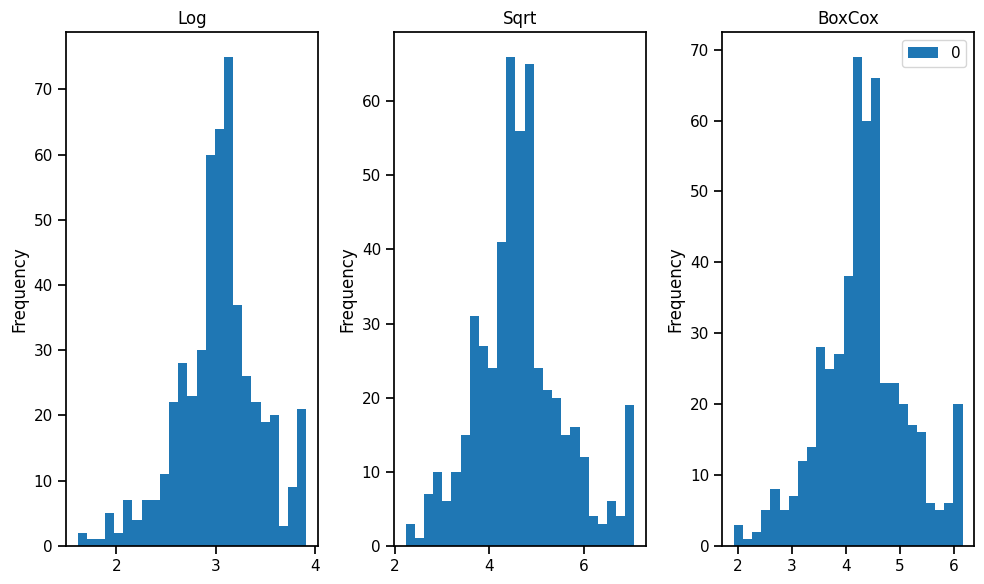

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
medv_log.plot.hist(ax=ax[0], title="Log", bins=25)
medv_sqrt.plot.hist(ax=ax[1], title="Sqrt", bins=25)
pd.DataFrame(medv_boxcox[0]).plot.hist(ax=ax[2], title="BoxCox", bins=25)
plt.tight_layout()

Both the p-value and the graph support that the BoxCox transformation has worked well in transforming the data more towards being normally distributed. So let's stick with this one.

## Linear Regression

Now we can build a regression model and start transforming our features.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from scipy.special import inv_boxcox

In [43]:
target_col = "MEDV"
test_size = 0.3
seed = 42

# Set up all models and transformations we need
lr = LinearRegression()
pf = PolynomialFeatures()
s = StandardScaler()

# Split into features (X) and target (y)
X = boston_data.drop(target_col, axis=1)
y = boston_data[target_col]

# Build polynomial features
X_pf = pf.fit_transform(X)

In [44]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=test_size, random_state=seed)

# Scale all input features using standard scaler
X_train_s = s.fit_transform(X_train)
# The test features must be scaled by the same scale as the train features, otherwise we will compare differently scaled values
X_test_s = s.transform(X_test)

# Apply boxcox transformation to target train variable
y_train_bc, bc_lambda = boxcox(y_train)

After all these transformations, we can now train our regression model and see how it performs.

In [45]:
# Fit the model
lr.fit(X_train_s, y_train_bc)
# Do predictions
y_pred_bc = lr.predict(X_test_s)
# Use inverse boxcox transformation to return the data to the original format for comparison
y_pred = inv_boxcox(y_pred_bc, bc_lambda)

Now we can finally calculate a performance metric. In this case we will simply take a look at $R^2$

In [48]:
f"The R^2 score of our model is: {r2_score(y_test, y_pred) * 100:.2f}%"

'The R^2 score of our model is: 81.82%'

Let's check what would happen if we trained without using the BoxCox transformation:

In [49]:
target_col = "MEDV"
test_size = 0.3
seed = 42

lr = LinearRegression()
pf = PolynomialFeatures()
s = StandardScaler()
X = boston_data.drop(target_col, axis=1)
y = boston_data[target_col]

X_pf = pf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=test_size, random_state=seed)
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

lr.fit(X_train_s, y_train)
y_pred = lr.predict(X_test_s)

f"The R^2 score of our model is: {r2_score(y_test, y_pred) * 100:.2f}%"

'The R^2 score of our model is: 66.94%'